In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import re
import seaborn as sns
%matplotlib inline

In [3]:
ratings = pd.read_csv("/content/drive/My Drive/AIML/Projects/Recommendation Engine/ratings_Electronics.csv", header= None)
ratings.head(10)

,0,1,2,3
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
5,A1QGNMC6O1VW39,0511189877,5.0,1397433600
6,A3J3BRHTDRFJ2G,0511189877,2.0,1397433600
7,A2TY0BTJOTENPG,0511189877,5.0,1395878400
8,A34ATBPOK6HCHY,0511189877,5.0,1395532800
9,A89DO69P0XZ27,0511189877,5.0,1395446400


In [0]:
ratings.columns = ['user_ID', 'item_id', 'Rating', 'timestamp']

In [5]:
print(ratings.shape)

(7824482, 4)


In [0]:
ratings.drop(['timestamp'],axis=1,inplace=True)

In [7]:
ratings.head()

,user_ID,item_id,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [8]:
ratings.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rating,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


In [9]:
ratings.Rating.unique()

array([5., 1., 3., 2., 4.])

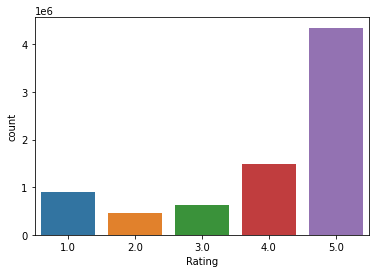

In [10]:
sns.countplot(data=ratings, x='Rating')

# **Popularity based recommendations**

In [11]:
ratings.groupby('item_id')['Rating'].mean().head()

item_id
0132793040    5.000000
0321732944    5.000000
0439886341    1.666667
0511189877    4.500000
0528881469    2.851852
Name: Rating, dtype: float64

In [12]:
ratings.groupby('item_id')['Rating'].mean().sort_values(ascending=False).head()

item_id
BT008V9J9U    5.0
B0058PPK8Y    5.0
B0058OQ9Q2    5.0
B0058OKSMS    5.0
B0058OHGX2    5.0
Name: Rating, dtype: float64

In [13]:
ratings.groupby('item_id')['Rating'].count().sort_values(ascending=False).head()

item_id
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: Rating, dtype: int64

In [0]:
ratings_mean_count = pd.DataFrame(ratings.groupby('item_id')['Rating'].mean())

In [0]:
ratings_mean_count['rating_counts'] = pd.DataFrame(ratings.groupby('item_id')['Rating'].count()) 

In [16]:
ratings_mean_count.sort_values('rating_counts',ascending=False).head()

,Rating,rating_counts
item_id,,
B0074BW614,4.491504,18244
B00DR0PDNE,3.931020,16454
B007WTAJTO,4.424005,14172
B0019EHU8G,4.754497,12285
B006GWO5WK,4.314657,12226


**The popularity based recommendations above are made more relevant by sorting on the rating counts. Without this sorting the recommendations do not indicate popularity of the items**

### The key observation here is that in its current state, the data is huge 238.8+ MB. It is imperative that the working is done on a smaller dataset. The size of dataset reduced however it is still high 179.1+ MB after removing timestamp column, however it is too high and will take a lot of computation power. Also the data contains users who may have rated very few items which is non consequential. Hence we will take only those uses who have rated atleast 50 items

## a. For more accurate results only consider users who have rated atleast 50 items

In [0]:
counts1 = ratings['user_ID'].value_counts()
# print(counts1)
ratings_CF = ratings[ratings['user_ID'].isin(counts1[counts1 >= 50].index)]

In [18]:
ratings_CF.head()

,user_ID,item_id,Rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [19]:
ratings_CF.shape

(125871, 3)

In [21]:
ratings_CF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125871 entries, 94 to 7824444
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_ID  125871 non-null  object 
 1   item_id  125871 non-null  object 
 2   Rating   125871 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.8+ MB


#### This size of the data is considerably reduced to 3.8 MB. This can be made sparse further.

# **Collaborative Filtering - User-based flitering**

In [23]:
! pip install scikit-surprise

     |████████████████████████████████| 6.5MB 2.5MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1673640 sha256=8788682872a8bdf8593643ad559744c9cdd7792283ffa4f28c7dd55a5d504123
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [0]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split


Since we are using custom data i.e. not bulitin data, need to use the Reader class from the surprise.dataset.load_from_df method.

In [0]:

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_CF[['user_ID', 'item_id', 'Rating']], reader)

# **Split the data randomly into train and test dataset.**

In [0]:
trainset, testset = train_test_split(data, test_size=.30)

For **user-based** collaborative filtering we need to pass user_based = true and use it to switch between user-based or item-based collaborative filtering.

In [27]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [0]:
test_pred = algo.test(testset)

In [29]:
test_pred

[Prediction(uid='A2DS9DLMSU2M2Z', iid='B003ICXCWA', r_ui=5.0, est=4.2620504148270895, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1QRST0A3IQIEF', iid='B001MQ4NJU', r_ui=5.0, est=4.2620504148270895, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='AEAFHD09X8044', iid='B00295RBQ0', r_ui=5.0, est=4.2620504148270895, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1ODOGXEYECQQ8', iid='B00D65AJ0C', r_ui=5.0, est=4.7164449198246725, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid='A3OXHLG6DIBRW8', iid='B001OBV7T2', r_ui=5.0, est=4.2620504148270895, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A38C12950IM24P', iid='B008GGH5HQ', r_ui=5.0, est=4.2620504148270895, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1IG1I6MR3HAWA', iid='B0014F9U6U', r_

In [30]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.0621


1.0621323073152356